In [1]:
%reload_ext autoreload
%autoreload 2
import nf
import numpy as np
import torch
from copy import deepcopy

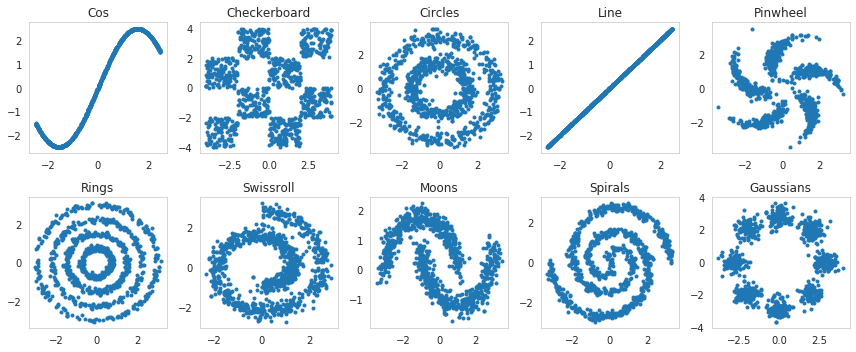

In [2]:
nf.util.plot_synthetic_datasets()

## Params

In [3]:
# Data
dim = 2
dataset = 'swissroll'

# Model
n_bins = 5
hidden_dim = 64
num_spline_layers = 5
num_hidden_layers = 2
spline_type = 'quadratic'

# Training
epochs = 100
batch_size = 128
eval_batch_size = batch_size
display_every = 10
patience = 20

## Load data

In [4]:
data = torch.Tensor(nf.load_dataset(dataset))

# Split into train, validation and test (60%-20%-20%)
ind1, ind2 = int(len(data) * 0.6), int(len(data) * 0.8)

train = torch.utils.data.TensorDataset(data[:ind1])
val = torch.utils.data.TensorDataset(data[ind1:ind2])
test = torch.utils.data.TensorDataset(data[ind2:])

dltrain = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
dlval = torch.utils.data.DataLoader(val, batch_size=eval_batch_size, shuffle=False)
dltest = torch.utils.data.DataLoader(test, batch_size=eval_batch_size, shuffle=False)

## Define a model

In [5]:
torch.manual_seed(123)

transforms = []
for i in range(num_spline_layers):
    transforms.append(nf.Coupling(
        nf.Spline(dim=dim, n_bins=n_bins, lower=-4, upper=4, latent_dim=hidden_dim, spline_type=spline_type),
        nf.net.MLP(dim, [hidden_dim] * num_hidden_layers, hidden_dim),
        mask='ordered_right_half' if i % 2 == 0 else 'ordered_left_half'
    ))

model = nf.Flow(torch.distributions.Normal(torch.zeros(dim), torch.ones(dim)), transforms)

## Train

In [6]:
optimizer = torch.optim.Adam(model.parameters())

impatient = 0
training_val_losses = []
times = []
best_loss = np.inf
best_model = deepcopy(model.state_dict())

for epoch in range(epochs):
    # Train step
    model.train()
    for x, in dltrain:
        optimizer.zero_grad()

        log_prob = model.log_prob(x)
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    loss_val = 0
    for x, in dlval:
        log_prob = model.log_prob(x)
        loss_val -= log_prob.sum()

    loss_val = loss_val.item() / len(val)
    training_val_losses.append(loss_val)

    # Early stopping
    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    # Logging
    if (epoch + 1) % display_every == 0:
        print(f"Epoch {epoch+1:4d}, loss_train = {loss:.4f}, loss_val = {loss_val:.4f}")

# Load best model
model.load_state_dict(best_model)
model.eval()

# Test model
loss_test = 0
for x, in dltest:
    log_prob = model.log_prob(x)
    loss_test -= log_prob.sum()
loss_test = loss_test.item() / len(test)

Epoch   10, loss_train = 2.9061, loss_val = 2.8114
Epoch   20, loss_train = 2.7517, loss_val = 2.7569
Epoch   30, loss_train = 2.5724, loss_val = 2.7317
Epoch   40, loss_train = 2.7214, loss_val = 2.7165
Epoch   50, loss_train = 2.6475, loss_val = 2.7157
Epoch   60, loss_train = 2.6078, loss_val = 2.7034
Epoch   70, loss_train = 2.7753, loss_val = 2.7265
Epoch   80, loss_train = 2.7962, loss_val = 2.6964
Epoch   90, loss_train = 2.7209, loss_val = 2.6929
Epoch  100, loss_train = 2.7528, loss_val = 2.6974


## Visualize

Area under curve 0.9899


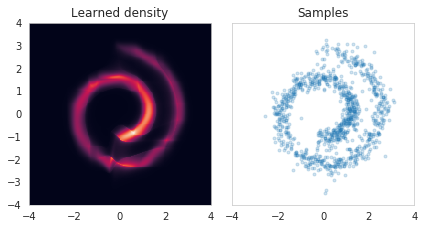

In [7]:
nf.util.plot_density(model, num_samples=1024)